##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 0. Setup

Uninstall TensorFlow เวอร์ชันที่อยู่ใน Colab, Install Version nightly แล้ว Restart Runtime

In [0]:
# !pip3 uninstall tensorflow
# !pip3 install tf-nightly

ใน ep นี้ เราจะใช้ TensorFlow 2 ด้วยคำสั่ง Magic %tensorflow_version 2.x (สำหรับ Google Colab)

In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

# 1. Import 

## 1.1 Import Library

Import Library ที่เกี่ยวข้อง และ Print เลข Version

In [0]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
# print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')
tf.config.list_physical_devices('GPU')

• Using TensorFlow Version: 2.1.0-rc1
• Using TensorFlow Hub Version:  0.7.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.2 เลือกโมดูล

เลือกโมดูล TensorFlow 2 ที่ต้องการจาก TensorFlow Hub

In [0]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4 with input size (299, 299) and output dimension 2048


# 2. Dataset

## 2.1 Split Data to Training / Validation / Test Set

เราจะใช้ TensorFlow Dataset `tfds` โหลดชุดข้อมูล เป่ายิ้งฉุบ Rock Paper Scissors Dataset ขึ้นมา แล้ว [Split Training / Validation / Test Set](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) ด้วยสัดส่วน 80/10/10

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

# Go to the TensorFlow Dataset's website and search for the Rock, Paper, Scissors dataset and load it here
splits, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

num_examples, num_classes

(2520, 3)

จะได้ [Dataset](https://www.bualabs.com/archives/1994/dataset-dataloader-feed-data-x-y-batch-to-neural-network-refactor-training-loop-neural-network-ep-5/) ที่มีข้อมูล 2520 ตัวอย่าง มี 3 Class

## 2.2 Transform

ประกาศฟังก์ชัน ใช้ `tf.image` เพื่อแปลงรูปใน Dataset ให้อยู่ในรูปแบบที่โมเดลต้องการ ในที่นี้คือ Resize เป็นขนาดที่กำหนด และ Rescale ค่าสี จาก 0-255 หาร 255 ให้เป็น Float 0-1

In [0]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

กำหนดขนาด [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) ให้ [DataLoader](https://www.bualabs.com/archives/1994/dataset-dataloader-feed-data-x-y-batch-to-neural-network-refactor-training-loop-neural-network-ep-5/)

In [0]:
BATCH_SIZE = 32 #@param {type:"integer"}

[Shuffle สับไพ่ข้อมูล](https://www.bualabs.com/archives/2054/dataloader-random-sampler-collate-feedforward-train-machine-learning-neural-network-ep-7/) และแบ่งข้อมูลเป็น Batch ตาม Batch Size ที่กำหนดด้านบน

In [0]:
# Prepare the examples by preprocessing the them and then batching them (and optionally prefetching them)

train_batches = train_examples.shuffle(num_examples//4).batch(BATCH_SIZE).map(format_image).prefetch(1)

validation_batches = validation_examples.batch(BATCH_SIZE).map(format_image).prefetch(1)

test_batches = test_examples.batch(1).map(format_image)

ดู shape ของข้อมูล 1 Batch จะได้ Batch Size = 32, Wigth = 299, Height = 299, Channels = 3

In [0]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 299, 299, 3])

ดูรูปตัวอย่าง

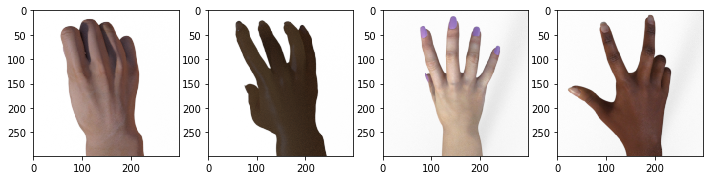

In [0]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(image_batch[i])

plt.show()

# 3. Model

เราทำ [Transfer Learning](https://www.bualabs.com/archives/3493/what-is-transfer-learning-build-headless-mobilenet-model-transfer-learning-machine-learning-mobilenet-json-retrain-webcam-tensorflow-js-tfjs-ep-10/) ด้วยการสร้าง 1 Dense Layer จาก Linear Classifier เป็น Head ต่อจาก feature_extractor_layer ของโมเดลที่โหลดมาจาก TensorFlow Hub

## 3.1 Fine-Tuning

เราสามารถกำหนดได้ว่า จะเทรน Fune-Tuning ทั้งโมเดลเลยหรือไม่ เพื่อเพิ่มความแม่นยำ หรือเทรนแค่ Head Layer สุดท้ายที่สร้างใหม่ก็พอ เพื่อประหยัดเวลา

In [0]:
do_fine_tuning = False #@param {type:"boolean"}

## 3.2 Pre-trained Model

ใช้ TensorFlow Hub โหลดโมเดล Pre-trained ที่เลือกด้านบนขึ้นมา กำหนด Hyperparameter ของโมเดล เช่น Input / Output Shape, Freeze โมเดลหรือไม่

In [0]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

## 3.3 Pre-trained Feature Extractor + Custom Head

สร้าง Head ด้วย 1 [Dense Layer](https://www.bualabs.com/archives/1763/what-is-neural-network-how-neural-network-work-build-deep-neural-network-from-scratch-neural-network-ep-1/) ที่มี [Activation Function](https://www.bualabs.com/archives/1261/what-is-activation-function-what-is-sigmoid-function-activation-function-ep-1/) เป็น [Softmax](https://www.bualabs.com/archives/1819/what-is-softmax-function-how-to-use-softmax-function-benefit-of-softmax/) และใส่ Dropout คั้นไว้จะได้ไม่ Overfit

In [0]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

ดู [Model Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/)

In [0]:
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


## 3.4 Unfreeze Layers

ในกรณีต้องการ Fine-Tuning เราสามารถเลือกได้ว่าจะ Unfreeze ถึง Layer ไหน เพื่อเทรนจาก Layer ท้ายสุดมาหน้า

In [0]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 4 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

## 3.5 Compile Model

ในเคสนี้ ถ้า Fine-Tuning เราจะใช้ [SGD](https://www.bualabs.com/archives/1619/linear-regression-sgd-stochastic-gradient-descent-machine-learning-basic-neural-networks-optimization-ep-2/) ส่วนถ้าไม่ เราจะใช้ Adam [Optimizer](https://www.bualabs.com/archives/2042/refactor-parameter-optimizer-neural-network-train-deep-learning-machine-learning-neural-network-ep-6/)

In [0]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# 4. Training the Model

เทรนไป 5 Epoch

In [0]:
EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
73/73 [==============================] - 18s 248ms/step - loss: 0.6178 - accuracy: 0.7346 - val_loss: 0.2693 - val_accuracy: 0.9429
Epoch 2/5
73/73 [==============================] - 14s 186ms/step - loss: 0.2395 - accuracy: 0.9327 - val_loss: 0.1605 - val_accuracy: 0.9750
Epoch 3/5
73/73 [==============================] - 13s 183ms/step - loss: 0.1639 - accuracy: 0.9537 - val_loss: 0.1099 - val_accuracy: 0.9857
Epoch 4/5
73/73 [==============================] - 13s 181ms/step - loss: 0.1163 - accuracy: 0.9756 - val_loss: 0.0812 - val_accuracy: 0.9929
Epoch 5/5
73/73 [==============================] - 14s 187ms/step - loss: 0.0955 - accuracy: 0.9756 - val_loss: 0.0674 - val_accuracy: 0.9929


# 5. Export the Model

Export โมเดลที่เทรนเสร็จเรียบร้อยแล้ว ในรูปแบบ ไฟล์ SavedModel Format

In [0]:
RPS_SAVED_MODEL = "rps_saved_model"

In [0]:
# Use TensorFlow's SavedModel API to export the SavedModel from the trained Keras model

tf.saved_model.save(model, export_dir=RPS_SAVED_MODEL)

INFO:tensorflow:Assets written to: rps_saved_model/assets


INFO:tensorflow:Assets written to: rps_saved_model/assets


ดูรายละเอียดของโมเดล ในไฟล์ SavedModel

In [0]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_3_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 299, 299, 3)
      name: serving_default_keras_layer_3_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


ลองโหลดโมเดลขึ้นมาดู

In [0]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

ดู Signature Input / Output Shape

In [0]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_3_input': TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_layer_3_input')})
{'dense_3': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense_3')}


# 6. Convert ไฟล์โมเดลด้วย TFLite Converter

ใช้ TFLiteConverter โหลดไฟล์โมเดล SavedModel ที่เรา Export ไว้ด้านบน

เราจะ Optimize โมเดล ด้วยการทำ Post-Training Quantization ลดจำนวน Bit ของ Parameter ในโมเดลลง เพื่อให้โมเดลมีขนาดเล็กลง และทำงานได้เร็วขึ้น จะอธิบายต่อไป ในเรื่อง [Quantization](https://www.bualabs.com/archives/3573/what-is-quantization-benefits-of-quantization-deep-neural-network-tflite-ep-2/)

เราสามารถเลือกได้ว่า จะให้ Optimize เพื่อ Latency, Size หรือ ทั้งสองอย่าง (Default)

## 6.1 TensorFlow v1

In [0]:
# converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
# converter.inference_type = tf.lite.constants.QUANTIZED_UINT8
# input_arrays = converter.get_input_arrays()
# converter.quantized_input_stats = {input_arrays[0] : (0., 1.)}  # mean, std_dev
# tflite_model = converter.convert()

## 6.2 TensorFlow v2

In [0]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.experimental_new_converter = True

# Set the optimization strategy for 'size' in the converter 
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

นอกเหนือจาก Parameter เราสามารถ Quantize ข้อมูล และ Activation ได้อีก โดยการให้ชุดข้อมูลตัวอย่าง รันผ่านโมเดล เพื่อเก็บสถิติ Representative Dataset วัด Dynamic Range ของข้อมูล และ Activation สร้าง Input Data Generator เพื่อส่งให้กับ Converter ใช้ในการทำ Post-Training Integer Quantization ต่อไป

In [0]:
## Still not working. Wait for TF team to fix bug in tflite converter
## Post-training integer quantization 

# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

# def representative_data_gen():
#     for image_batch, label_batch in train_batches.take(1):
#         yield [[image_batch[0]]]

# converter.representative_dataset = representative_data_gen

โมเดลที่แปลงแล้ว จะยังรับ Input / Output เป็น Float เหมือนเดิมเพื่อความสะดวก จะได้ไม่ต้องแก้โปรแกรม

และ ในโมเดล ถ้า Ops ไหน ที่ไม่มี Quantized Implementation ก็จะใช้เป็น Floating Point Implementation เหมือนเดิม แบบนี้จะทำให้การ Convert โมเดลทำได้อย่างราบรื่น แต่ก็จะจำกัดให้รันได้เฉพาะ Hardware ที่รองรับ Floating Point

## 6.3 Convert โมเดลเป็น ไฟล์ FlatBuffer .tflite

Convert โมเดลเป็นไฟล์ tflite แล้ว Save ลง Disk

In [0]:
# Use the tool to finally convert the model
tflite_model = converter.convert()

In [0]:
tflite_model_file = 'converted_model.tflite'

In [0]:
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

# 7. Test ไฟล์ tflite ด้วย TFLite Intepreter

ใช้ TFLite Intepreter โหลดไฟล์ tflite ขึ้นมา

In [0]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

ดู Signature ของโมเดล ดู Shape และ Type ของ Input และ Output 

In [0]:
interpreter.get_input_details(), interpreter.get_output_details()

([{'dtype': numpy.float32,
   'index': 0,
   'name': 'keras_layer_3_input',
   'quantization': (0.0, 0),
   'shape': array([  1, 299, 299,   3], dtype=int32)}],
 [{'dtype': numpy.float32,
   'index': 313,
   'name': 'Identity',
   'quantization': (0.0, 0),
   'shape': array([1, 3], dtype=int32)}])

สุ่มเลือก 10 รูปจาก Test Set มาให้โมเดล ทำ Inference

In [0]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

10it [00:07,  1.37it/s]


นำผลลัพธ์ที่ได้ มาพล็อตแสดงรูป เปรียบเทียบ label และ prediction

<class 'numpy.int64'> <class 'numpy.int64'>


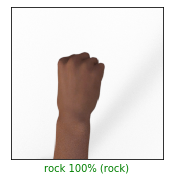

In [0]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

<class 'numpy.int64'> <class 'numpy.int64'>


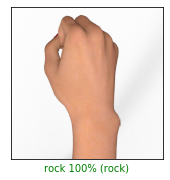

In [0]:
index = 3 
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

สร้างไฟล์เก็บ Label

In [0]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

# 8. Save และ Download ไฟล์ tflite

Save ไฟล์ และ Download โมเดล และ Label มาที่ Local Disk เพื่อนำไปใส่ Device ที่ต้องการต่อไป

หมายเหตุ: เราอาจจะต้อง กดอนุญาตให้ Web Browser สามารถ Download หลาย ๆ ไฟล์ได้พร้อมกัน

In [0]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

# 9. Credit

* https://www.coursera.org/learn/device-based-models-tensorflow/
* https://www.bualabs.com/archives/3595/what-is-tensorflow-lite-converter-convert-mobilenet-transfer-learning-classifier-head-deploy-mobile-iot-edge-device-microcontroller-tflite-ep-3/
* https://www.tensorflow.org/datasets/catalog/rock_paper_scissors
* https://github.com/lmoroney/dlaicourse/tree/master/TensorFlow%20Deployment
* https://www.tensorflow.org/lite/convert